In [41]:
# things we will need to do stuff in this notebook
%pip install umap-learn
import numpy as np
import pandas as pd
from scipy import stats
from numpy.linalg import norm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

# two useful data viz libraries
import matplotlib.pyplot as plt
#import seaborn as sns

# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
#sns.set_style("white")
#sns.set_context("notebook")

Note: you may need to restart the kernel to use updated packages.


In [42]:
from PIL import Image
import numpy as np
import os
from sklearn.metrics.pairwise import euclidean_distances

# Default parameters of the images
default_width = 136
default_length = 102
default_dimension = default_width * default_length # this change is for the grayscale to work 
#num_of_channels = 3
#default_dimension = 35625

# Load in all of the images stored in the sneakers folder
# Define the collection of images
image_collection = np.zeros((1, default_dimension))
print(f"image_collection shape is: {image_collection.shape}")
# Pathway to the main folder that holds all types of shoes
main_path = "./sneakers"
# Makes a list of folder names found in the main folder
folders = os.listdir(main_path)
# Iterates through those folder names
for i, folder in enumerate(folders):
    # Keeps track of progress of folder dive
    print(f"Inside folder {i+1}: {folder}")
    # Creates the pathway to the folder inside the main folder 
    folder_path = os.path.join(main_path, folder)
    # List all files in the folder
    files = os.listdir(folder_path)
    # Iterate through all of the files and add them to the collection of flattened images
    for file in files:
        # Creates the pathway to the images inside the folder
        image_path = os.path.join(folder_path, file)
        # Loads the images into the notebook as a list and then changes it to a numpy array
        image_list = Image.open(image_path)
        
        image_gray = image_list.convert('L')  # Convert to grayscale
        image_np = np.array(image_gray)

        #image_np = np.array(image_list)
        # Remove rows and columns
       # rows_to_delete = [0, 1, 2, -1, -2, -3, -4]
       # cols_to_delete = [0, 1, 2, 3, 4, 5, -1, -2, -3, -4, -5]
       # image_np = np.delete(image_np, rows_to_delete, axis=0)
       # image_np = np.delete(image_np, cols_to_delete, axis=1)
       #temp comment it out for the grayscale stuff to work 
        
        # Flatten the image
        image_flat = image_np.reshape(1, -1)
        # If this is the first image, index instead of stack inside the collection
        if i == 0:
            image_collection[0] = image_flat
        else:
            image_collection = np.vstack((image_collection, image_flat))
# for loop ends here
print(f"image_collection shape is: {image_collection.shape}")

image_collection shape is: (1, 13872)
Inside folder 1: Reebok
Inside folder 2: Paul Smith
Inside folder 3: DVS Shoe Company
Inside folder 4: DSQUARED2
Inside folder 5: Amiana
Inside folder 6: Aetrex
Inside folder 7: ALDO
Inside folder 8: Lacoste
Inside folder 9: AlexanderMcQueen
Inside folder 10: AdidasOriginals
Inside folder 11: GUESS
Inside folder 12: Easy Spirit
Inside folder 13: Crocs
Inside folder 14: UGG
Inside folder 15: adidasY-3
Inside folder 16: BetseyJohnson
Inside folder 17: Nike
Inside folder 18: SKECHERS
Inside folder 19: ECCO
Inside folder 20: Converse
Inside folder 21: KangaROOS
image_collection shape is: (1988, 13872)


[ 50.  46.  45.  43.  40.  42.  43.  40.  38.  39.  46.  44.  43.  46.
  39.  39.  39.  34.  24.  46.  42. 131. 255. 252. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 254. 254. 254. 102.  24.  47.  42.  43.  51.
  54.  51.  65.  63.  54.  54.  48.  52.  49.  51.  48.  49.  50.  44.
  40.  47.  24.   7.  13.  44.  42.  36.  39.  45.  50.  61.  58.  59.
  52.  53.  52.  58.  53.  44.  43.  42.  42.  45.  47.  45.  43.  41.
  40.  42.  44.  43.  48.  47.  42.  46.  44.  39.  45.  47.  44.  38.
  38.  39.  56. 141. 253. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255. 255.
 255. 

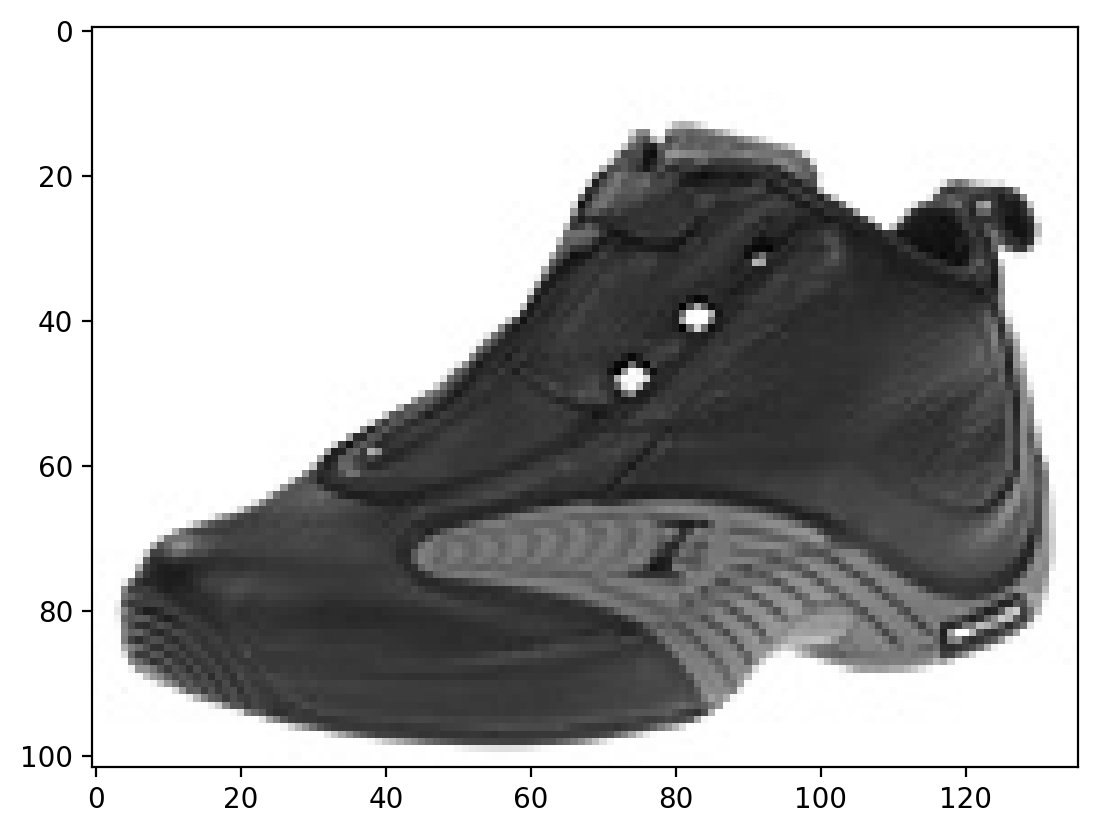

In [43]:
print(image_collection[0, 5000:5200])
#plt.imshow(image_collection[0].astype(int).reshape((95, 125, 3)))
# was giving error when running with the greyscale code so i skipped it 
plt.imshow(image_collection[0].reshape((default_length, default_width)), cmap='gray')
plt.show()

In [44]:
# Preprocess the data
# Because of the curse of dimensionality, we'll use UMAP to reduce the dimensionality
image_collection_mean = np.mean(image_collection, axis=0, keepdims=True)
print(f"image_collection_mean shape: {image_collection_mean.shape}")

# Mean centered data
mean_centered_data = image_collection - image_collection_mean

n_components = 2
#umap_v1 = UMAP(n_neighbors=15, n_components=n_components, random_state=99, min_dist=0.05) #lowered the n_neighbors from 40 and the min_dist from 0.07
tsne_v1 = TSNE(n_components=n_components,perplexity=60,random_state=99)
reduced_image_collection = tsne_v1.fit_transform(mean_centered_data)

image_collection_mean shape: (1, 13872)


In [45]:
num_clusters = 25 #started at 20 and have increased
clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')  
cluster_labels = clustering.fit_predict(reduced_image_collection)

In [46]:
print(cluster_labels[:800])
print(len((np.unique(cluster_labels))))

[17 13  1 18  2 13  7  7 12 12 11  8 14  9  9 19  9  4  9 11  4 18  9 17
 12 12  6 14  9 18 19 12  4 11 17 14 11 18 11  1 14  9  9 18 12 17 10  9
 14  9  8 14  8  9 17  9 14 24  9 23  9  9 11  9  2  9  1 14 14  9  9 18
  8  9 19  9 11  9 24 12  8  0  0 20  3  7  7 13  8  2  2  1  8  1  0  1
  1 20 20  1 13  1 23  1 15  1  1  7 23 23  2  1  1 22 22  8 22  1  8  9
  4 18 23  3  8  8 23  8 23 23 23  8 17  0  8 23 23 18  8  0 18  0  2  8
  8 18 20  2  7  8 18 14  8  2  8 18 23 18  8  8 18  8 14 21  8  0 11 12
  8 18  2 18  8  8 18 19 23  3 21 23  8 18  8  8 10 18  8 18 18  8  2  8
  8  0  2  2  8  2  8  2  0  3 21  8  2  1  1 18  8 23  0  2  0  8  0 21
  2  2  8 18 14  2  0  8  2 18 18 18  6  8  6  7  2  2  0  8 18  6  0  2
 18  0  0  6  8 18  8  8 18  2 23  8 10 12  0  5  2  2 18  8  2  2  0  7
  2 18  0  8  7 12  0  2 18 23  2  8  0  8 18  2 14  0  7 20  8 13  0  2
 13 13 11 15  6  4 13 24 15  2 11 16  1  7 24 11  7 12 14  1 12  1 16 11
  5  2 22 16 13  7 13 16 16  1 11  1  7 13 16 17  1

In [47]:
max_number_of_clusters = max(cluster_labels)+1  # Get the maximum cluster label
cluster_to_samples = {}

for elem in cluster_labels:
    if elem in cluster_to_samples:
        cluster_to_samples[elem] += 1
    else:
        cluster_to_samples[elem] = 1

print(f"The max number of clusters found were: {max_number_of_clusters}")  # Add 1 to account for cluster labels starting from 0
print(cluster_to_samples)
# Be careful about the clusters that only have 1 data sample to it 

The max number of clusters found were: 25
{17: 70, 13: 74, 1: 125, 18: 51, 2: 148, 7: 81, 12: 90, 11: 81, 8: 122, 14: 56, 9: 94, 19: 47, 4: 118, 6: 114, 10: 63, 24: 34, 23: 51, 0: 106, 20: 39, 3: 86, 15: 46, 22: 42, 21: 58, 5: 112, 16: 80}


In [48]:
#Find Centroids
def find_centroids(labels, num_of_clusters, data):
    cluster_means = np.zeros((num_of_clusters, 2))
    for i in range(num_of_clusters):  # Start from 0 and iterate up to num_of_clusters - 1
        # Finds the points associated with cluster i
        indices = labels == i
        cluster_means[i] = np.sum(data[indices, :], axis=0) / np.sum(indices)
    return cluster_means

In [49]:
centroids = find_centroids(cluster_labels, max_number_of_clusters, reduced_image_collection)
print(centroids.shape)
print(centroids)

(25, 2)
[[ 10.45498466 -13.43888378]
 [ 23.03971672   9.81079388]
 [ 26.83456421   1.02296293]
 [ 18.19017982  -1.15172362]
 [ 13.830966    11.09861088]
 [-20.14846802   8.54537678]
 [  1.23396707  -5.79957914]
 [ 10.0146904   -5.14521408]
 [-14.87230206 -20.55700302]
 [-20.13817215 -11.77193642]
 [ -8.26808739  -9.72828484]
 [-11.68248272   4.71110344]
 [-26.37965202  -1.27088237]
 [ -5.60373735  21.32316589]
 [ -6.07018948 -19.38451576]
 [  3.60092688  19.98014259]
 [ -0.54421973   9.04679298]
 [-17.53613472  -3.75643539]
 [  4.90194178 -21.08031654]
 [ -6.89194441  -2.11254001]
 [  5.44394684   4.15851831]
 [ -0.25765514 -14.98000813]
 [-26.54670715   7.58296299]
 [ -8.98978329  16.01129341]
 [ 29.69904709   9.56958389]]


In [50]:
def visualize_clusters(umap_embeddings, cluster_labels, centroids):
 
    num_clusters = len(np.unique(cluster_labels))
    
    colors = plt.cm.get_cmap('tab20', num_clusters)
    
    # Create a scatter plot of the UMAP embeddings with each cluster colored differently
    plt.figure(figsize=(8, 6))
    for i, cluster_label in enumerate(np.unique(cluster_labels)):
        plt.scatter(umap_embeddings[cluster_labels == cluster_label, 0], 
                    umap_embeddings[cluster_labels == cluster_label, 1], 
                    label=f'Cluster {cluster_label}', color=colors(i))
    for i in range(num_clusters):
        plt.scatter(centroids[i, 0], centroids[i, 1], color='black', marker='x', s=100)
        plt.text(centroids[i, 0], centroids[i, 1], f'Centroid {i}', fontsize=10, verticalalignment='bottom')

    plt.title('Clusters Visualization')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    ncolsint = 4
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols=ncolsint)
    plt.show()

/var/folders/y3/8fq070r15zvgth8g2j9l9kfr0000gn/T/ipykernel_47519/1607341628.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_clusters)


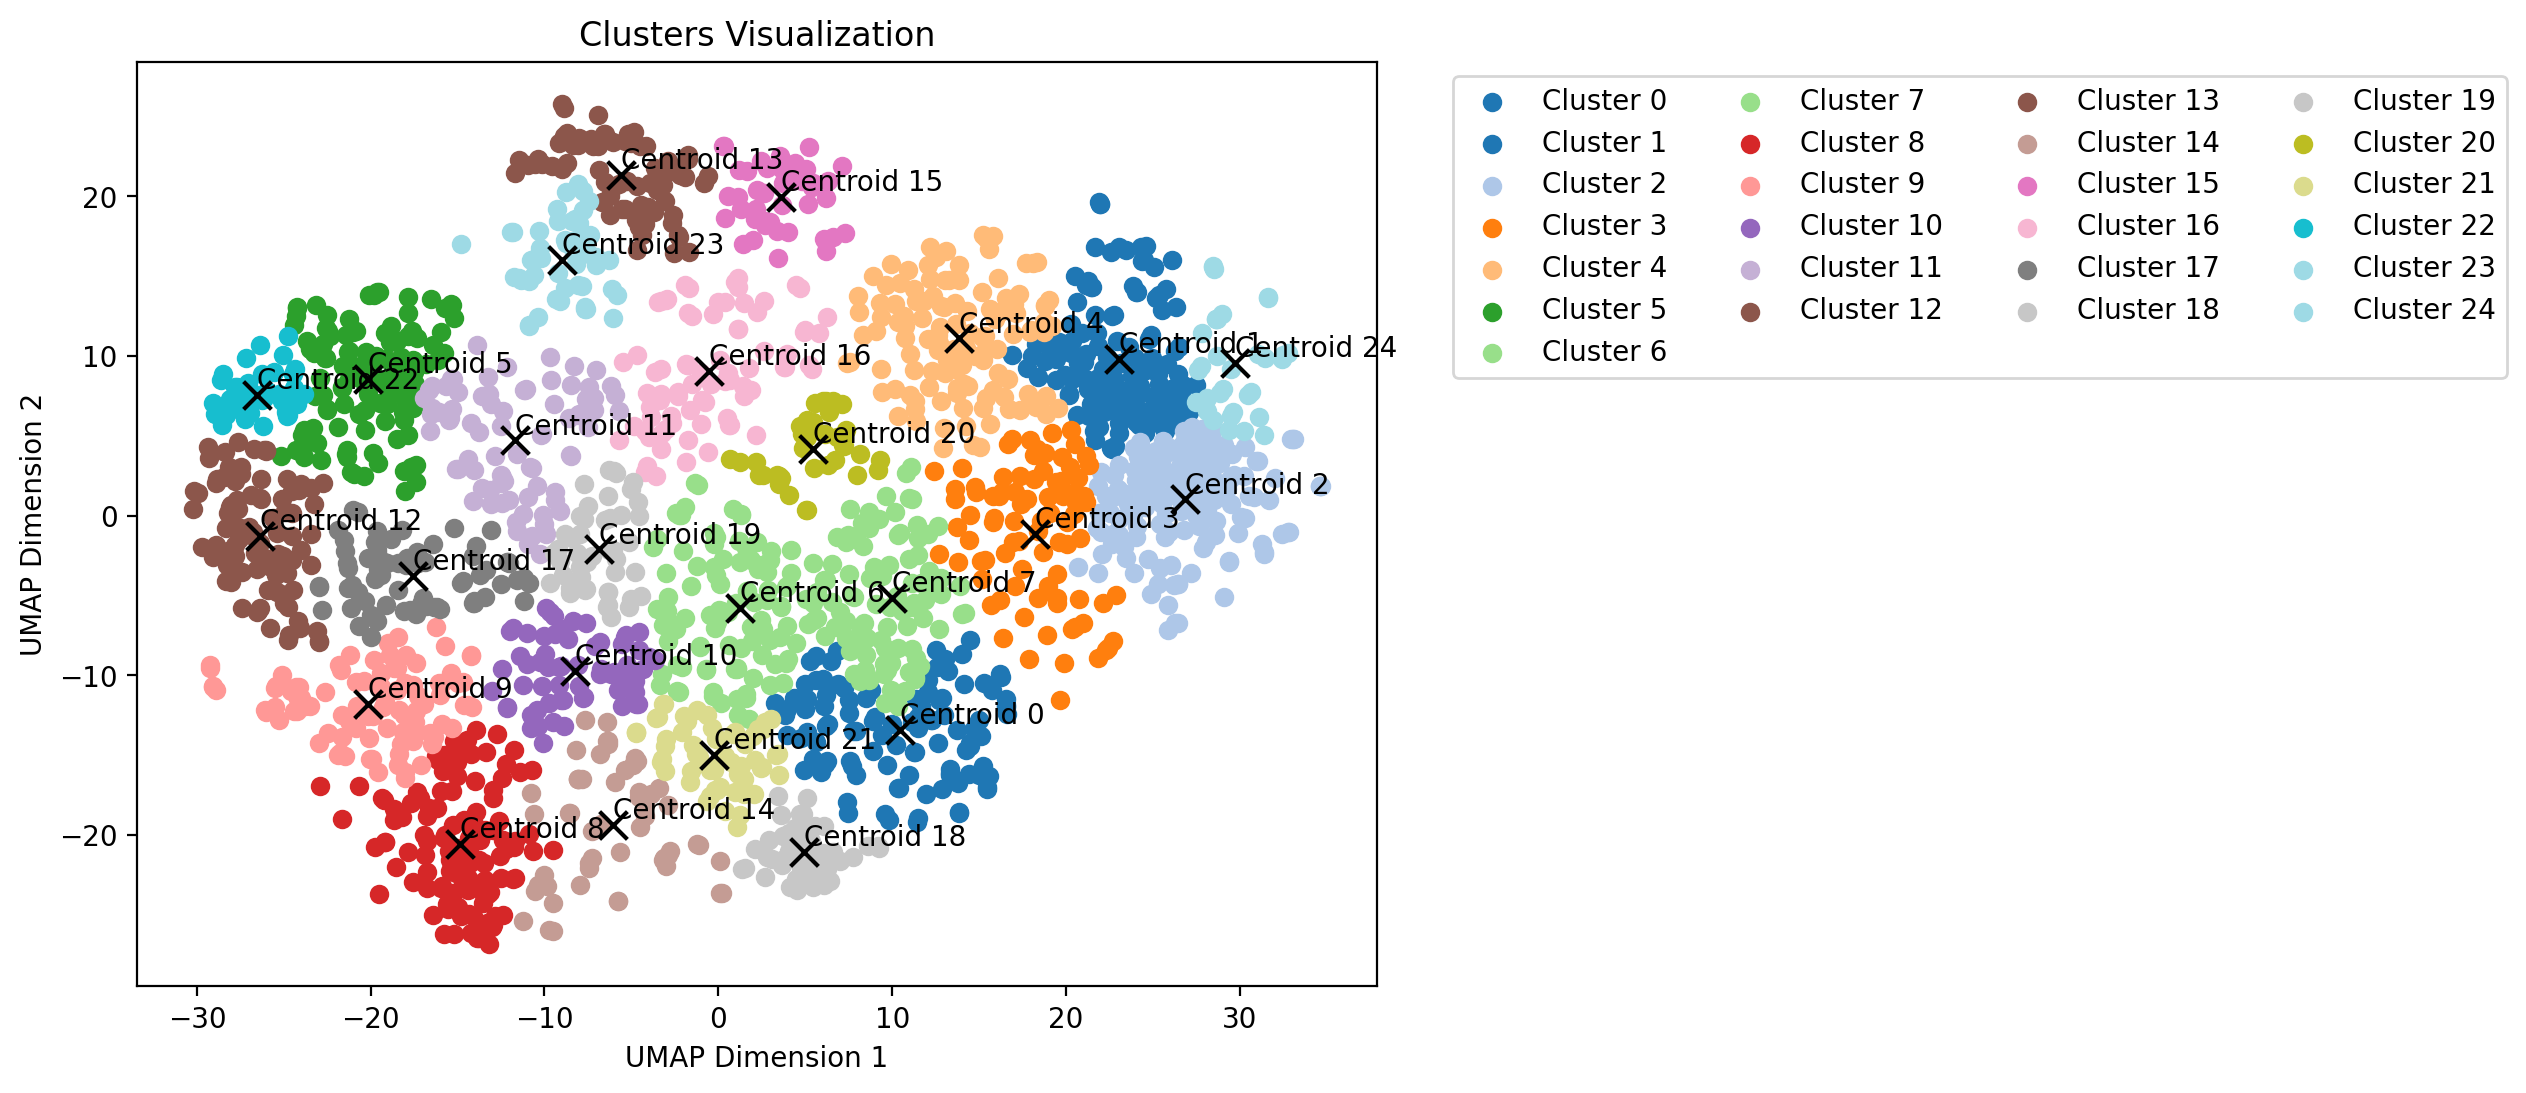

In [51]:
# New Clustering
visualize_clusters(reduced_image_collection, cluster_labels,centroids)

/var/folders/y3/8fq070r15zvgth8g2j9l9kfr0000gn/T/ipykernel_47519/1607341628.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', num_clusters)


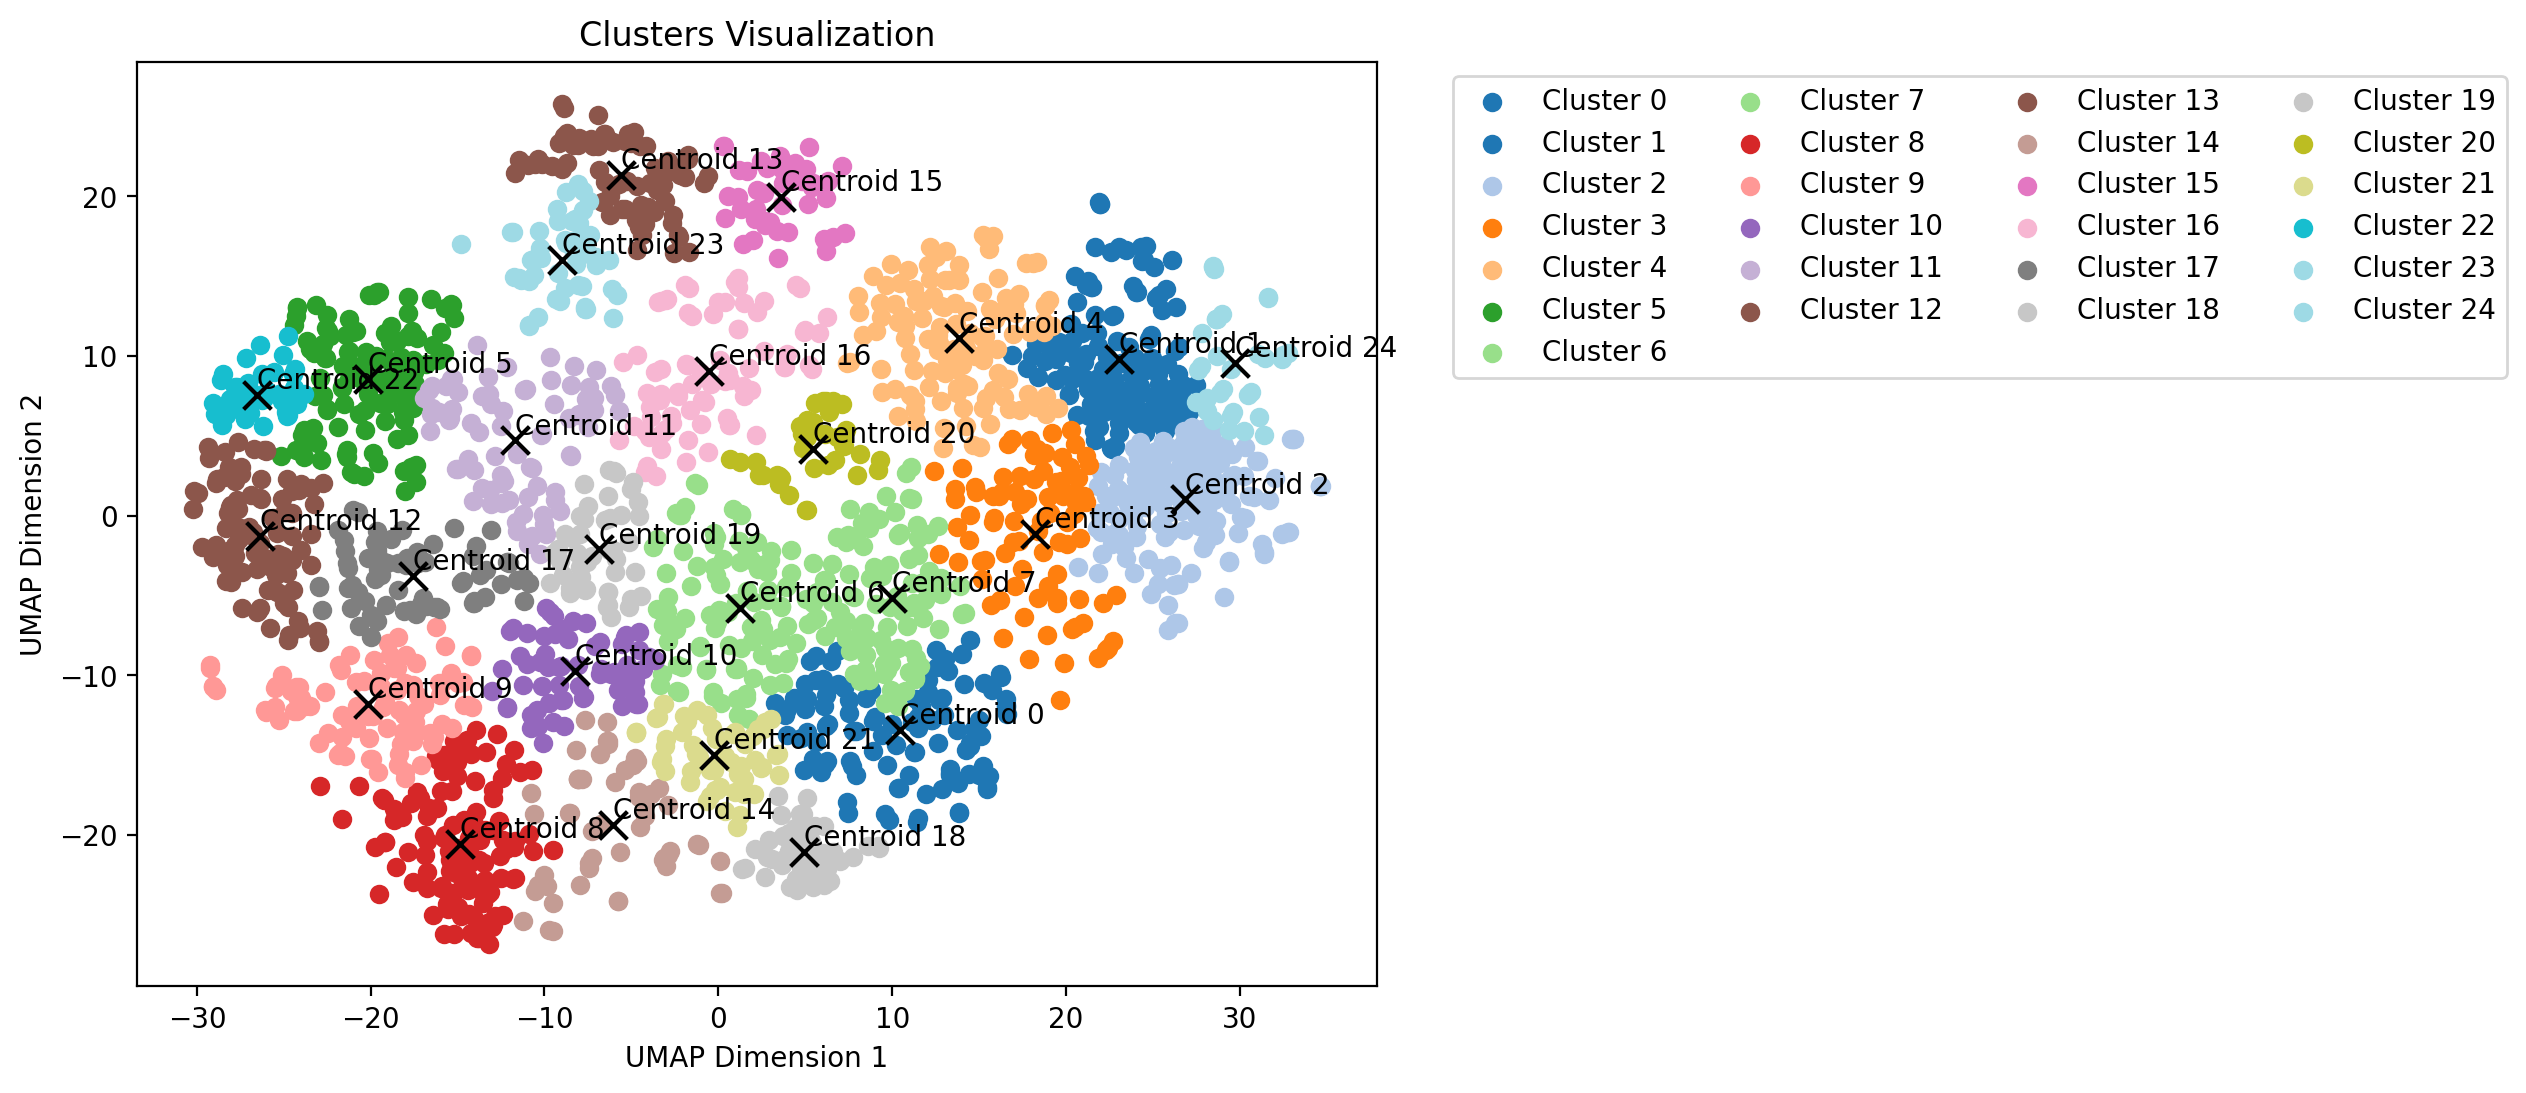

In [52]:
# Old Clustering
visualize_clusters(reduced_image_collection, cluster_labels,centroids)

In [53]:
def input_image_preprocesser(pathway, tsne_arg):
    # Loads the images into the notebook as a list and then changes it to a numpy array
    image_list = Image.open(pathway)
    
    image_gray = image_list.convert('L')  # Convert to grayscale
    image_np = np.array(image_gray)
        
    #image_np = np.array(image_list)
    # Remove rows and columns, comment out this whole section for the greyscale to work
  #  rows_to_delete = [0, 1, 2, -1, -2, -3, -4]
  #  cols_to_delete = [0, 1, 2, 3, 4, 5, -1, -2, -3, -4, -5]
  #  image_np = np.delete(image_np, rows_to_delete, axis=0)
  #  image_np = np.delete(image_np, cols_to_delete, axis=1)
  #  print(f"Image Shape: {image_np.shape}")
    # Image truncated shape: (95, 125, 3)
    
    # Flatten the image
    image_flat = image_np.reshape(1,-1) # (1, 200)
    print(image_flat.shape)
    print(image_collection_mean.shape)
    image_flat=image_flat-image_collection_mean
    
    return image_flat

In [54]:
def predict_cluster_label(umap_embedding, clustering_model):
    # Use the trained clustering model to predict the cluster label for the UMAP embedding
    cluster_label = clustering_model.fit_predict(umap_embedding.reshape(1, -1))
    return cluster_label

In [55]:
# Assuming 'input_image_path' is the path to the input image
input_image = input_image_preprocesser("test/7999507.254650.jpg",tsne_v1)

#adjusted code for the grayscaling
umap_embedding_input = np.expand_dims(input_image, axis=0)
umap_embedding_input = umap_embedding_input[0] #for the grayscale need to reduce more dim
print("reduced image collection:")
print(reduced_image_collection.shape)
print("Input Image:")
print(umap_embedding_input.shape)

"""
    This essentially puts the transformed image at the end of mean centered data then I do the fit transform
    on the combined dataset to get the predicted cluster label.
"""

umap_embeddings_combined = np.concatenate((mean_centered_data, umap_embedding_input), axis=0)
X_tsne = tsne_v1.fit_transform(umap_embeddings_combined)
#umap_embeddings_combined = np.concatenate((reduced_image_collection, input_image), axis=0)
cluster_labels = clustering.fit_predict(X_tsne)
predicted_cluster_label = cluster_labels[-1]
print("Predicted Cluster Label:", predicted_cluster_label)

(1, 13872)
(1, 13872)
reduced image collection:
(1988, 2)
Input Image:
(1, 13872)
Predicted Cluster Label: 0


156
[255. 255. 255. ... 255. 255. 255.]


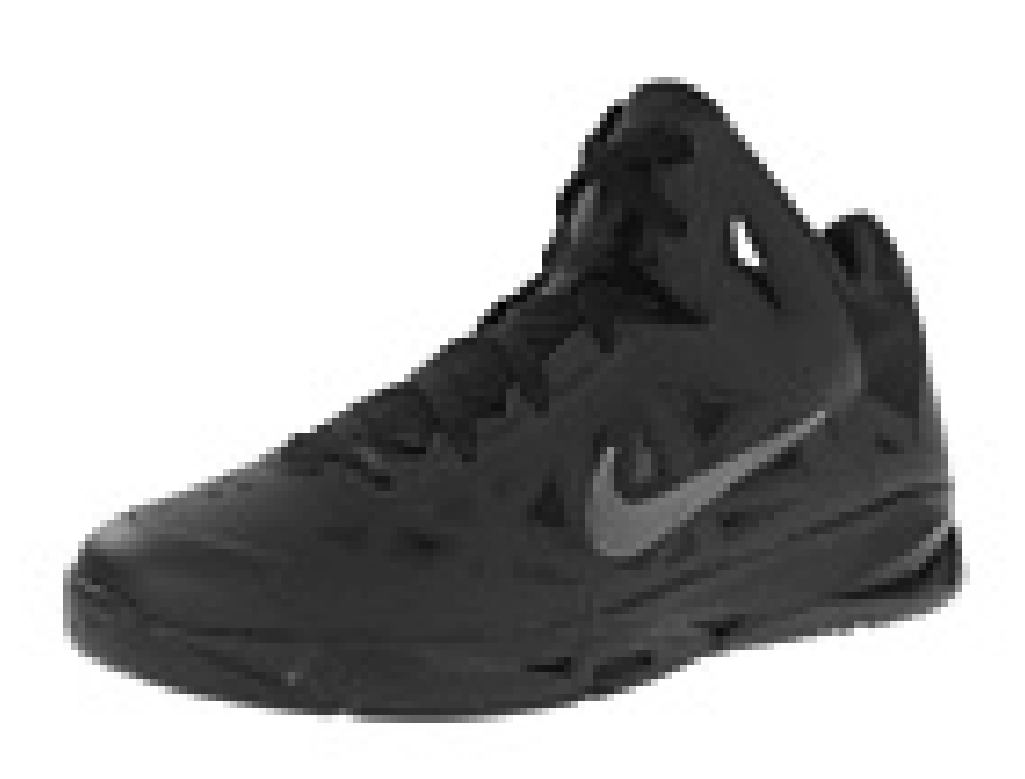

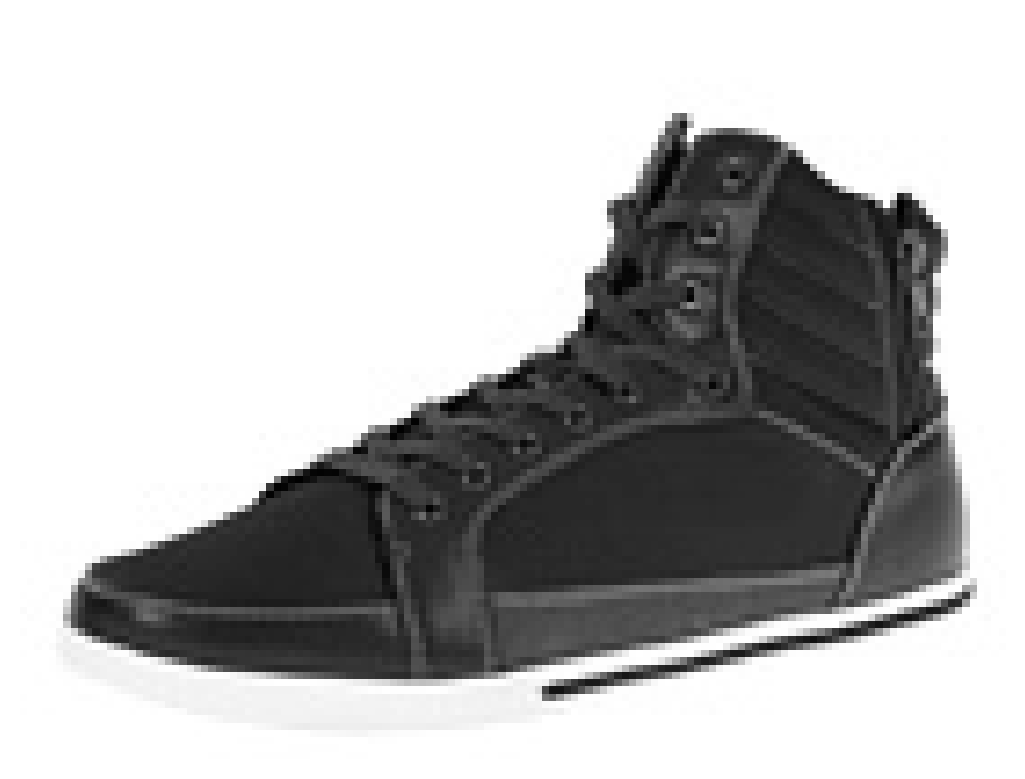

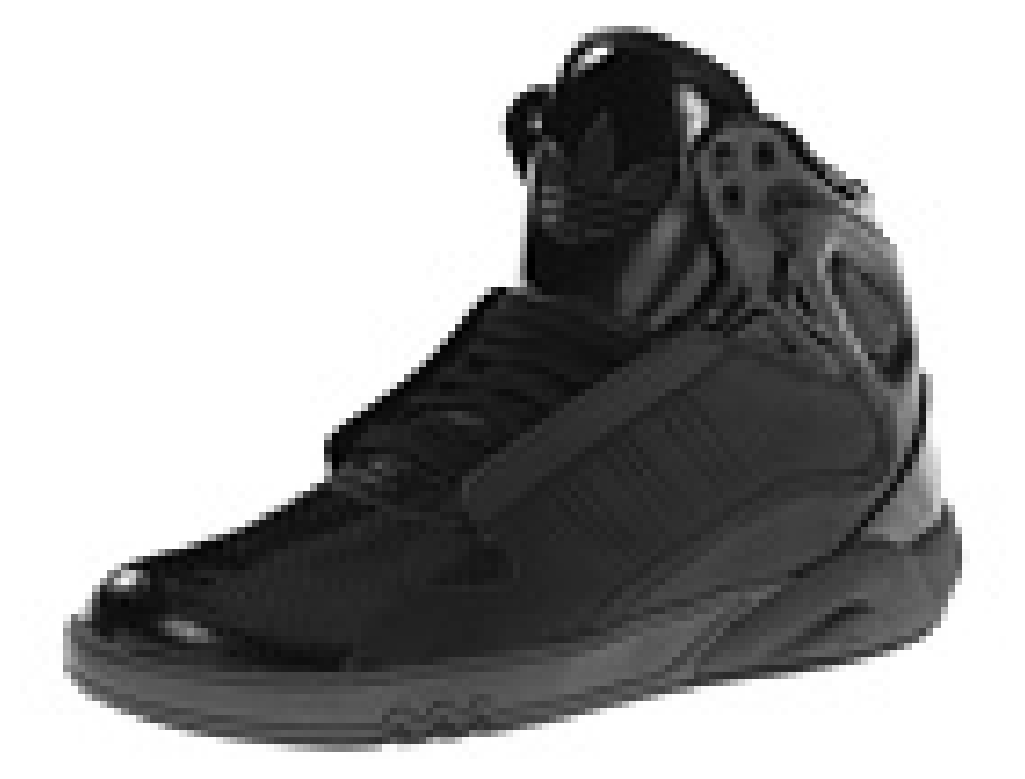

Selected Images from the Cluster: [1406, 128, 438]


In [56]:
cluster_indices = np.where(cluster_labels == predicted_cluster_label)[0]
print((len(cluster_indices)))
# Randomly select three indices from the cluster (excluding the input image)
import random
random_indices = random.sample(list(cluster_indices), min(3, len(cluster_indices)))

print(image_collection[random_indices[0]])

for i in random_indices:
    #plt.imshow((image_collection[i].reshape((95, 125, 3))).astype(int))
    plt.imshow(image_collection[i].reshape((default_length, default_width)), cmap='gray')#new image size reshape for the grayscale

    plt.axis('off')  # Turn off axis
    plt.show()

print("Selected Images from the Cluster:", random_indices)

In [57]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

def plot_silhouette_score(umap_embedding, labels):
    silhouette_scores = silhouette_samples(umap_embedding, labels)
    silhouette_avg = silhouette_score(umap_embedding, labels)
    
    # Create a subplot with 1 row and 1 column
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 15)
    y_lower = 10
    
    for i in range(len(set(labels))):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = silhouette_scores[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / len(set(labels)))
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([]) 
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

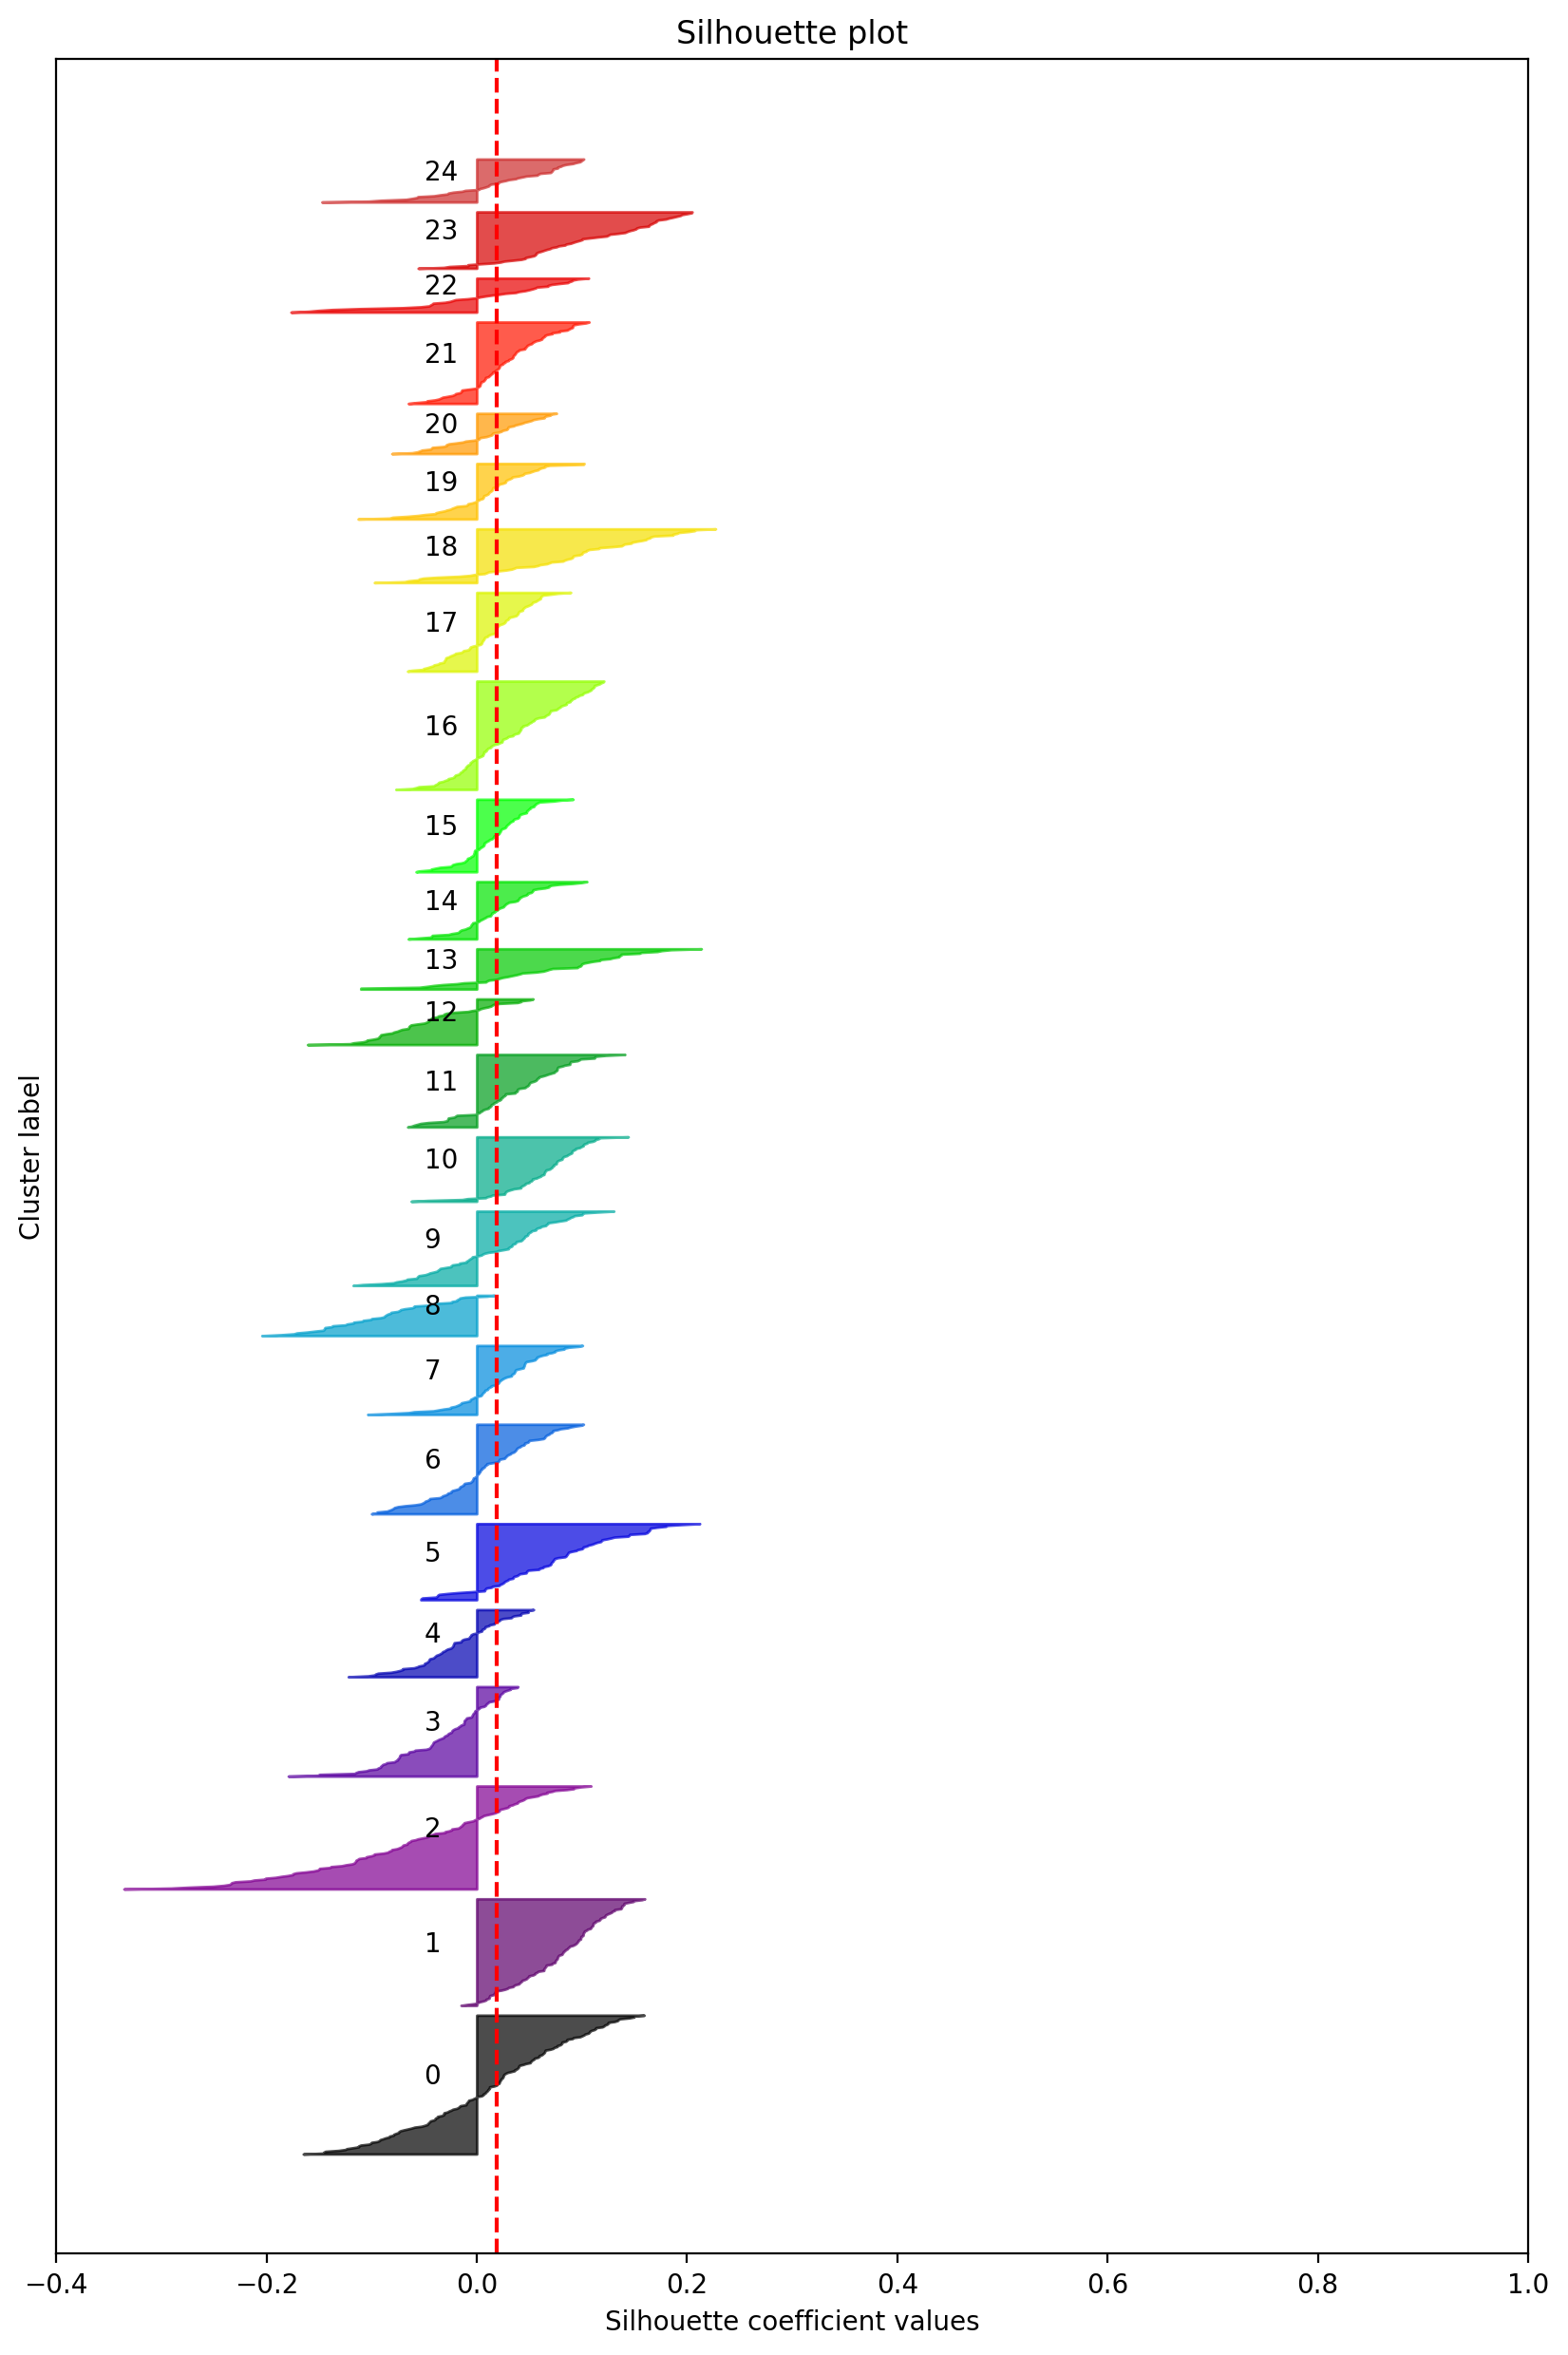

Silhouette Score: 0.019396267657152258


In [58]:
plot_silhouette_score(umap_embeddings_combined, cluster_labels)

silhouette_avg = silhouette_score(umap_embeddings_combined, cluster_labels)
print("Silhouette Score:", silhouette_avg)